In [2]:
!pip install -q kaggle
!pip install -q albumentations

In [11]:
!kaggle competitions download -c planttraits2024

100% 3.49G/3.50G [00:42<00:00, 169MB/s]
100% 3.50G/3.50G [00:43<00:00, 87.3MB/s]


In [ ]:
!unzip '/content/planttraits2024.zip'

In [269]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, ConcatDataset, DataLoader, Subset, random_split
from torchvision import transforms

from sklearn.model_selection import train_test_split

import re

In [294]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
random_state = 7

np.random.seed(0)

random.seed(0)

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [295]:
TRAIN_IMAGES_PATH = '/content/train_images'
TEST_IMAGES_PATH = '/content/test_images'

# Untility functions

In [296]:
mean_pattern = r'X\d+_mean'
sd_pattern = r'X\d+_sd'

In [297]:
def find_matching_elements(lst,pattern):
    matching_elements = [element for element in lst if re.search(pattern, element)]
    return matching_elements

In [298]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [299]:
train_df.sample(10)

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
24886,184873835,-1.032917,574.295227,90.252380,62.482738,1227.480225,42.762859,87,144,125,...,0.174163,0.645791,0.433834,615.749773,NaN,NaN,NaN,NaN,NaN,NaN
31965,190494649,0.440794,589.538086,48.000000,33.024284,1090.136475,39.804287,54,149,118,...,0.554565,1.121493,1.130741,725.767936,0.002047,0.909884,0.073212,0.059998,0.042375,30.941051
28421,195642066,17.284445,341.909515,65.457146,89.490135,544.396545,31.776667,138,163,151,...,0.439074,0.601914,1.030841,304.821680,0.003821,0.326769,0.027901,0.153138,0.013564,16.485387
12674,164426751,12.075297,166.142853,24.500000,49.969826,902.658264,38.064285,129,148,141,...,0.199941,3.176854,2.202036,509.618373,NaN,NaN,NaN,NaN,NaN,NaN
31158,186882920,17.013542,1030.795898,266.556122,91.027039,177.292847,14.822959,107,117,112,...,0.231805,0.051018,1.190324,89.976644,0.005543,0.221099,0.025756,0.024287,0.015604,5.421096
45443,195637432,-0.526925,317.861908,87.438095,113.449104,1096.622192,40.898571,108,146,128,...,0.359241,1.062527,1.332752,3322.765956,NaN,NaN,NaN,NaN,NaN,NaN
19727,194871319,20.958969,2068.119141,264.828583,53.143101,488.990204,19.647144,115,144,128,...,0.232182,0.041521,2.149017,669.891966,NaN,NaN,NaN,NaN,NaN,NaN
20600,186386731,18.402203,563.590454,81.157143,64.466095,437.827026,24.329046,121,136,131,...,0.230897,0.500619,0.942541,608.056653,NaN,NaN,NaN,NaN,NaN,NaN
24052,164361896,17.402231,870.571411,82.178574,35.694508,825.165405,35.850002,148,174,162,...,0.283748,0.163265,1.672265,62.625917,NaN,NaN,NaN,NaN,NaN,NaN
35949,195065314,11.712444,437.182220,34.533333,28.756390,632.724487,29.993334,127,155,137,...,0.009491,0.147462,1.895993,9.095304,0.005892,0.749986,0.000848,0.008639,0.137162,1.257774


In [300]:
len(train_df.columns), len(test_df.columns)

(176, 164)

In [301]:
len(train_df), len(test_df)

(55489, 13873)

In [302]:
targets = [col for col in train_df.columns if col not in test_df.columns]

In [303]:
metadata_columns = [col for col in train_df.columns if col in test_df.columns and col != 'id']

# Augmentation

In [322]:
class AlbumentationsTransform:
    def __init__(self, augmentation):
        self.augmentation = augmentation

    def __call__(self, img):
        img_np = np.array(img)
        augmented = self.augmentation(image=img_np)
        return augmented['image']

train_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.2),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.5),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2, fill_value=0, p=0.5),
    A.Sharpen(alpha=0.3, lightness=0.3, p=0.5),
    A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=3, shadow_dimension=50, p=0.5),
    A.Resize(256, 256)
])

test_val_augmentation = A.Compose([
    A.Resize(256, 256)
])

final_transforms = transforms.Compose([
    AlbumentationsTransform(test_val_augmentation),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


In [316]:
class PlantTraits2024_Dataset(Dataset):
    def __init__(self, df, columns, images_path, augmentation=None,
                 transform=None, augment_times=1, metadata_columns=None,
                 augment_metadata=False,
                 metadata_augmentation_std=0.1):

        self.df = df
        self.columns = columns
        self.images_path = images_path
        self.augmentation = augmentation
        self.transform = transform
        self.augment_times = augment_times
        self.augment_metadata = augment_metadata
        self.metadata_augmentation_std = metadata_augmentation_std

    def __len__(self):
        return len(self.df) + self.augment_times

    def __getitem__(self, idx):
        original_idx = idx // self.augment_times
        id = self.df.iloc[original_idx, 0]
        image_path = f'{self.images_path}/{id}.jpeg'
        bgr_image = cv2.imread(image_path)
        image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        filtered_df = self.df[self.df['id'] == id].iloc[0]

        meta_data = torch.as_tensor(filtered_df[self.columns].to_numpy().astype(np.float64))

        if (self.augment_metadata):
          meta_data = self.augment_tabular_data(meta_data)

        if self.augmentation:
            image = AlbumentationsTransform(self.augmentation)(image)

        if self.transform:
            image = self.transform(image)

        return image, meta_data

    def augment_tabular_data(self, meta_data):
        noise = np.random.normal(0, self.metadata_augmentation_std, meta_data.shape)
        augmented_meta_data = meta_data + noise
        return torch.as_tensor(augmented_meta_data, dtype=torch.float32)

    def get_original_image_and_metadata(self, idx):
        image_name = self.df.iloc[idx, 0]
        image_path = f'{self.images_path}/{image_name}.jpeg'
        bgr_image = cv2.imread(image_path)
        image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

        metadata = self.df.iloc[idx][self.columns].to_numpy().astype(np.float64)
        metadata = torch.tensor(metadata, dtype=torch.float64)

        return image, metadata

In [317]:
def shorten_feature_name(name, max_length=15):
    if len(name) > max_length:
        return name[:max_length - 3] + "..."
    return name

def visualize_augmentations(dataset, idx, title, augment_times=4, n_features=5):
    features_to_display = dataset.columns[:n_features]
    original_image, original_metadata = dataset.get_original_image_and_metadata(idx)

    fig, axes = plt.subplots(1, augment_times + 1, figsize=(20, 4))
    fig.suptitle(title, fontsize=16)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    original_image = np.array(original_image)
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    for i in range(augment_times):
        augmented_image, augmented_metadata = dataset[idx * augment_times + i]
        augmented_image = augmented_image.permute(1, 2, 0).numpy()
        augmented_image = std * augmented_image + mean
        augmented_image = np.clip(augmented_image, 0, 1)
        axes[i + 1].imshow(augmented_image)
        axes[i + 1].set_title(f"Aug Version {i+1}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

    header = ["Feature"] + ["Original"] + [f"Aug Version {i+1}" for i in range(augment_times)]
    header_format = "{:<30}" + "{:<15}" * (1 + augment_times)
    print(header_format.format(*header))

    for feature in features_to_display:
        shortened_feature = shorten_feature_name(feature)
        row = [shortened_feature] + [f"{original_metadata[dataset.columns.index(feature)].item():.2f}"]
        for i in range(augment_times):
            _, augmented_metadata = dataset[idx * augment_times + i]
            row.append(f"{augmented_metadata[dataset.columns.index(feature)].item():.2f}")
        print(header_format.format(*row))

In [307]:
def split_dataframe(train_df, test_df, train_size=0.8, val_size=0.2):
    if train_size + val_size != 1:
        raise ValueError("train_size, val_size, and test_size must sum to 1")

    train_df, val_df = train_test_split(train_df, train_size=train_size, random_state=random_state)
    return train_df, val_df, test_df

In [308]:
def create_dataset(train_df, test_df, columns, targets, train_images_path, test_images_path, augment_times):
    train_df, val_df, test_df = split_dataframe(train_df, test_df)

    train_dataset = PlantTraits2024_Dataset(train_df, columns + targets, train_images_path, augmentation=train_augmentation, transform=final_transforms, augment_times=augment_times, augment_metadata=True)
    val_dataset = PlantTraits2024_Dataset(val_df, columns + targets, train_images_path, augmentation=test_val_augmentation, transform=final_transforms, augment_times=augment_times)
    test_dataset = PlantTraits2024_Dataset(test_df, columns, test_images_path, augmentation=test_val_augmentation, transform=final_transforms, augment_times=augment_times)

    return train_dataset, val_dataset, test_dataset

In [323]:
train_dataset, val_dataset, test_dataset = create_dataset(train_df, test_df, metadata_columns, targets, TRAIN_IMAGES_PATH, TEST_IMAGES_PATH, augment_times=5)

In [324]:
len(train_dataset), len(val_dataset), len(test_dataset)

(44396, 11103, 13878)

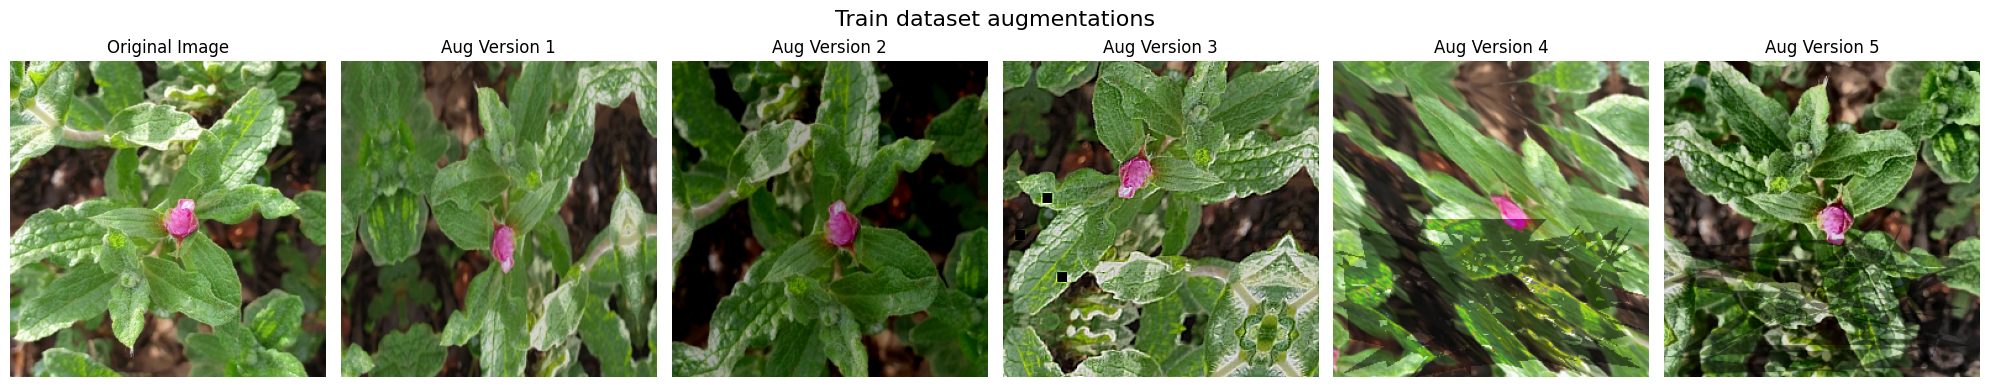

Feature                       Original       Aug Version 1  Aug Version 2  Aug Version 3  Aug Version 4  Aug Version 5  
WORLDCLIM_BI...               16.30          16.37          16.34          16.27          16.29          16.42          
WORLDCLIM_BI...               555.97         555.91         555.86         556.06         556.10         556.04         
WORLDCLIM_BI...               95.60          95.74          95.63          95.50          95.52          95.71          
WORLDCLIM_BI...               68.09          68.14          68.13          68.15          67.98          67.94          
WORLDCLIM_BI...               396.73         396.74         396.73         396.49         396.73         396.85         


In [325]:
visualize_augmentations(dataset=train_dataset, title='Train dataset augmentations', idx=14, augment_times=5)

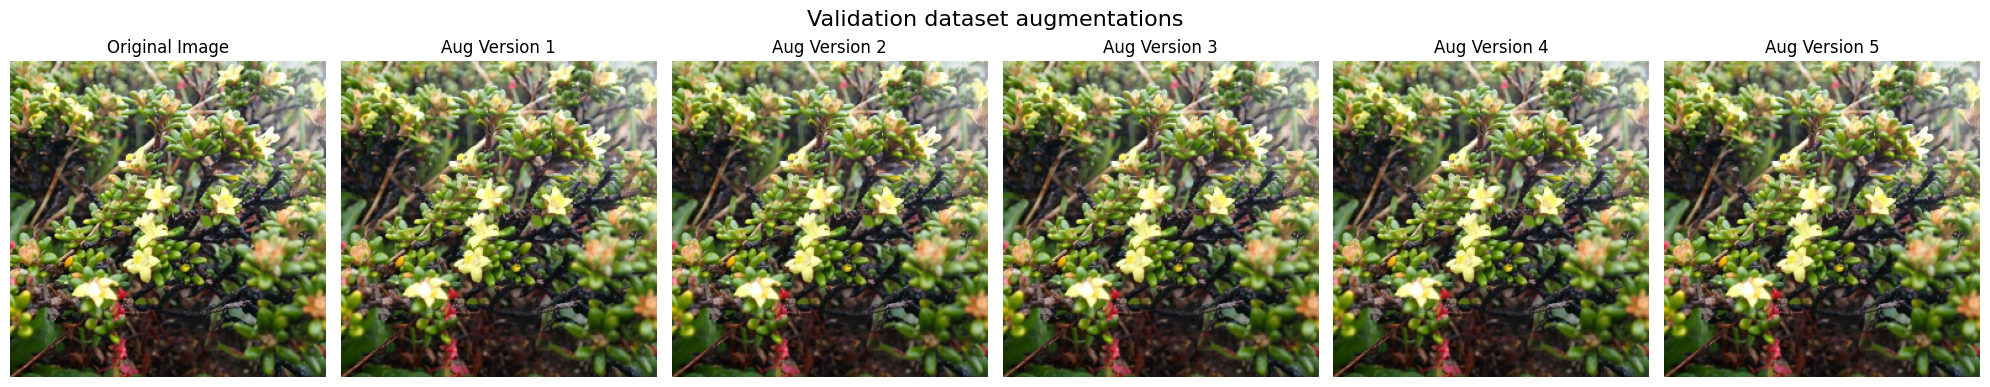

Feature                       Original       Aug Version 1  Aug Version 2  Aug Version 3  Aug Version 4  Aug Version 5  
WORLDCLIM_BI...               6.51           6.51           6.51           6.51           6.51           6.51           
WORLDCLIM_BI...               1662.97        1662.97        1662.97        1662.97        1662.97        1662.97        
WORLDCLIM_BI...               105.17         105.17         105.17         105.17         105.17         105.17         
WORLDCLIM_BI...               25.28          25.28          25.28          25.28          25.28          25.28          
WORLDCLIM_BI...               499.79         499.79         499.79         499.79         499.79         499.79         


In [326]:
visualize_augmentations(dataset=val_dataset, title='Validation dataset augmentations', idx=14, augment_times=5)

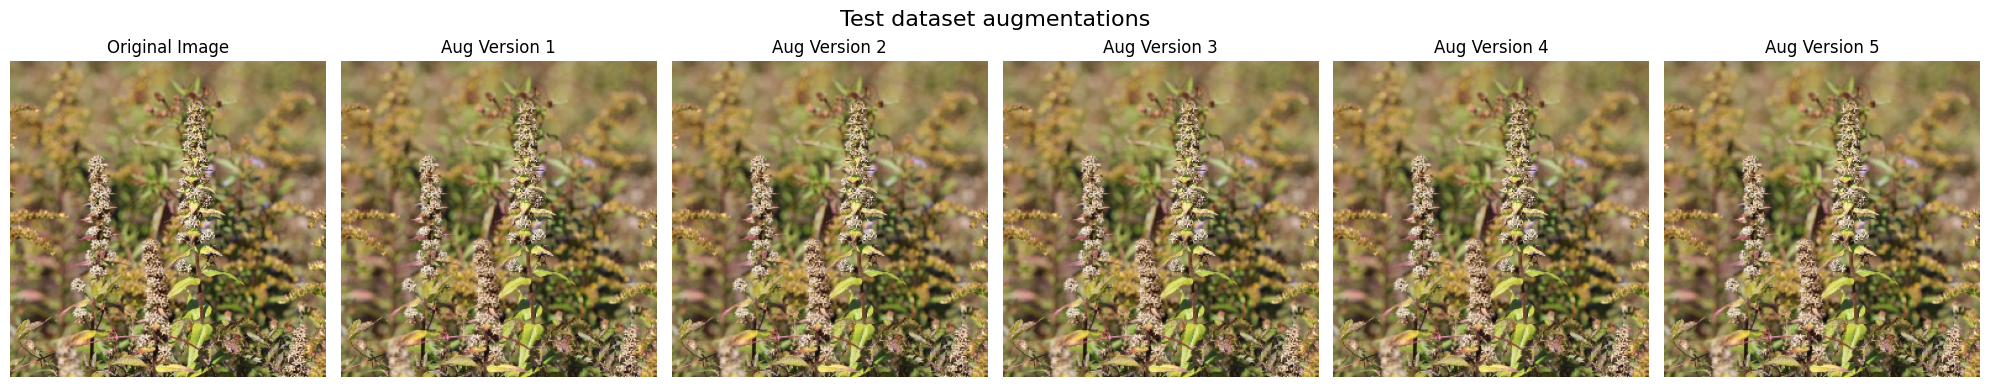

Feature                       Original       Aug Version 1  Aug Version 2  Aug Version 3  Aug Version 4  Aug Version 5  
WORLDCLIM_BI...               8.39           8.39           8.39           8.39           8.39           8.39           
WORLDCLIM_BI...               1300.60        1300.60        1300.60        1300.60        1300.60        1300.60        
WORLDCLIM_BI...               38.13          38.13          38.13          38.13          38.13          38.13          
WORLDCLIM_BI...               10.50          10.50          10.50          10.50          10.50          10.50          
WORLDCLIM_BI...               808.91         808.91         808.91         808.91         808.91         808.91         


In [327]:
visualize_augmentations(dataset=test_dataset, title='Test dataset augmentations', idx=14, augment_times=5)